# This notebook provides the functionality to build, train, and test a CNN for predicting mosquito age, grouped age, species, and status.

## Structure:
* Import packages to be used.
* Load mosquito data.
* Define fucntions for plotting, visualisation, and logging.
* Define a function to build the CNN.
* Define a function to train the CNN.
* Main section to organise data, define the CNN, and call the building and training of the CNN.


In [1]:
import umap
# import seaborn as sns

# import pylab as pl
import datetime
import pandas as pd
import itertools
from itertools import cycle
import pickle
import random as rn
import os
from time import time
from tqdm import tqdm

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.dates import date2num

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils import resample

import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras import layers, metrics
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import model_from_json, load_model
from keras.regularizers import *
from keras.callbacks import CSVLogger
from keras import backend as K

Using TensorFlow backend.


In [2]:
# rand_seed = np.random.randint(low=0, high=100)
rand_seed = 16
print(rand_seed)

16


In [3]:
os.environ['PYTHONHASHSEED'] = '0'

## The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(42)

## The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)

## Force TensorFlow to use single thread.
## Multiple threads are a potential source of
## non-reproducible results.
## For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
# session_conf = tf.ConfigProto(device_count = {'GPU':0}, intra_op_parallelism_threads=4) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# session_conf = tf.ConfigProto(device_count = {'GPU':0}) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#session_conf.gpu_options.per_process_gpu_memory_fraction = 0.5
## The below tf.set_random_seed() will make random number generation
## in the TensorFlow backend have a well-defined initial state.
## For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)

sess = tf.Session(graph=tf.get_default_graph(), config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

## Load the data

The data file is created using Loco Mosquito:
https://github.com/magonji/MIMI-project/blob/master/Loco%20mosquito%204.0.ipynb

### The data file has headings: Species - Status - RearCnd - Age - Country- Frequencies

In [24]:
class data_loader_class():
    def __init__(self):
        df = pd.read_csv("../../../Data/mosquitoes_country_LM_5_0.dat", '\t')
        df.head(10)
        RearCnd_counts = df.groupby('RearCnd').size()

        df['AgeGroup'] = 0
        df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

        df_vf = df[df['RearCnd']=='VF']
        df_vf = df_vf[df_vf['Status']=='UN']
        df = df[df['RearCnd']!='VF']
        df = df[df['Status']!='UN']
        df_l = df[df['RearCnd']=='TL']
        df_l_g = df_l[df_l['Country']=='S']
        df_l_g_a = df_l_g[df_l_g['Species']=='AA']
        age_counts = df_l_g_a.groupby('AgeGroup').size()
        df_l_g_g = df_l_g[df_l_g['Species']=='AG']
        age_counts = df_l_g_g.groupby('AgeGroup').size()
        df_l_g_c = df_l_g[df_l_g['Species']=='AC']
        age_counts = df_l_g_c.groupby('AgeGroup').size()
        df_l_t = df_l[df_l['Country']=='T']
        df_l_t_a = df_l_t[df_l_t['Species']=='AA']
        age_counts = df_l_t_a.groupby('AgeGroup').size()
        df_l_t_g = df_l_t[df_l_t['Species']=='AG']
        age_counts = df_l_t_g.groupby('AgeGroup').size()
        df_l_b = df_l[df_l['Country']=='B']
        df_l_b_g = df_l_b[df_l_b['Species']=='AG']
        age_counts = df_l_b_g.groupby('AgeGroup').size()
        df_l_b_c = df_l_b[df_l_b['Species']=='AC']
        age_counts = df_l_b_c.groupby('AgeGroup').size()
        df_f = df[df['RearCnd']=='TF']
        df_f_t = df_f[df_f['Country']=='T']
        df_f_t_a = df_f_t[df_f_t['Species']=='AA']
        age_counts = df_f_t_a.groupby('AgeGroup').size()
        # df_f_t_g = df_f_t[df_f_t['Species']=='AG'] #There isn't any
        df_f_b = df_f[df_f['Country']=='B']
        df_f_b_g = df_f_b[df_f_b['Species']=='AG']
        age_counts = df_f_b_g.groupby('AgeGroup').size()
        df_f_b_c = df_f_b[df_f_b['Species']=='AC']
        age_counts = df_f_b_c.groupby('AgeGroup').size()
        df_vf_t = df_vf[df_vf['Country']=='T']
        df_vf_t_a = df_vf_t[df_vf_t['Species']=='AA']
        age_counts = df_vf_t_a.groupby('AgeGroup').size()
        df_vf_t_g = df_vf_t[df_vf_t['Species']=='AG']
        age_counts = df_vf_t_g.groupby('AgeGroup').size()
        df_vf_b = df_vf[df_vf['Country']=='B']
        df_vf_b_g = df_vf_b[df_vf_b['Species']=='AG']
        age_counts = df_vf_b_g.groupby('AgeGroup').size()
        df_vf_b_c = df_vf_b[df_vf_b['Species']=='AC']
        age_counts = df_vf_b_c.groupby('AgeGroup').size()

        size_inc = 400
        for age in range(3):
            df_temp = df_l_t_a[df_l_t_a['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            if age == 0:
                df_train = df_temp.iloc[index_df_temp_inc]
        #         df_test = df_temp.iloc[index_df_temp_not_inc]
            else:
                df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
        #         df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_l_t_g[df_l_t_g['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
        #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        size_inc = 400
        for age in range(3):
            df_temp = df_l_b_g[df_l_b_g['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
        #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_l_b_c[df_l_b_c['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
        #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        size_inc = 300 # 50
        for age in range(3):
            df_temp = df_f_t_a[df_f_t_a['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            if age == 0:
                df_trainf = df_temp.iloc[index_df_temp_inc]
        #         df_test = df_temp.iloc[index_df_temp_not_inc]
            else:
                df_trainf = pd.concat([df_trainf, df_temp.iloc[index_df_temp_inc]])
        #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_f_b_g[df_f_b_g['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_trainf = pd.concat([df_trainf, df_temp.iloc[index_df_temp_inc]])
        #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_f_b_c[df_f_b_c['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_trainf = pd.concat([df_trainf, df_temp.iloc[index_df_temp_inc]])
        #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        size_inc = 0
        for age in range(3):
            df_temp = df_vf_t_a[df_vf_t_a['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
            if age == 0:
                df_test = df_temp.iloc[index_df_temp_not_inc]
            else:
                df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_vf_t_g[df_vf_t_g['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
            df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        size_inc = 0
        for age in range(3):
            df_temp = df_vf_b_g[df_vf_b_g['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
            df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_vf_b_c[df_vf_b_c['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            np.random.seed(42)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
            df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])

        X = df_train.iloc[:,6:-1]
        y_age = df_train["Age"]
        y_age_groups = df_train["AgeGroup"]
        y_species = df_train["Species"]
        y_status = df_train["Status"]
        self.X = np.asarray(X)
        y_age = np.asarray(y_age)
        self.y_age_groups = np.asarray(y_age_groups)
        self.y_species = np.asarray(y_species)
        y_status = np.asarray(y_status)

        print(f'Original lab/field data shapes:')
        print('shape of X : {}'.format(X.shape))
        print('shape of y age : {}'.format(y_age.shape))
        print('shape of y age groups : {}'.format(y_age_groups.shape))
        print('shape of y species : {}'.format(y_species.shape))
        print('shape of y status : {}'.format(y_status.shape))

#         Xf = df_trainf.iloc[:,6:-1]
#         y_agef = df_trainf["Age"]
#         y_age_groupsf = df_trainf["AgeGroup"]
#         y_speciesf = df_trainf["Species"]
#         y_statusf = df_trainf["Status"]
#         Xf = np.asarray(Xf)
#         y_agef = np.asarray(y_agef)
#         y_age_groupsf = np.asarray(y_age_groupsf)
#         y_speciesf = np.asarray(y_speciesf)
#         y_statusf = np.asarray(y_statusf)

#         print('shape of X f : {}'.format(Xf.shape))
#         print('shape of y age f : {}'.format(y_agef.shape))
#         print('shape of y age groups f : {}'.format(y_age_groupsf.shape))
#         print('shape of y species f : {}'.format(y_speciesf.shape))
#         print('shape of y status f : {}'.format(y_statusf.shape))

#         X_vf = df_test.iloc[:,6:-1]
#         y_age_vf = df_test["Age"]
#         y_age_groups_vf = df_test["AgeGroup"]
#         y_species_vf = df_test["Species"]
#         y_status_vf = df_test["Status"]
#         X_vf = np.asarray(X_vf)
#         y_age_vf = np.asarray(y_age_vf)
#         y_age_groups_vf = np.asarray(y_age_groups_vf)
#         y_species_vf = np.asarray(y_species_vf)
#         y_status_vf = np.asarray(y_status_vf)




In [25]:
def data_loader(valid_perc, seed):
    return data_loader_class(valid_perc, seed)

In [26]:
class wild_data_loader():
    def __init__(self, species_choice='all'):
        df = pd.read_csv("../../../Data/mosquitoes_wild_w_dates.dat", '\t')
#         print(df.head(10))

        df_test = df[df.Status.isin(['UN', 'BF'])]
        df_bf = df[df.Status.isin(['BF'])]
        df_wg = df[df.Status.isin(['WG'])]
        print(f"blood fed with species AA : {np.asarray(df_bf[df_bf['Species']=='AA']).shape}")
        print(f"blood fed with species AC : {np.asarray(df_bf[df_bf['Species']=='AC']).shape}")
        print(np.asarray(df_bf).shape)
        print(np.asarray(df_wg).shape)
        df = df[df['Status']!='UN']
        df = df[df['Status']!='BF']
        df = df[df['Status']!='WG']
        
#         df['AgeGroup'] = np.where(df['Status']=='NP', 0, np.where(df.Status.isin(['P1', 'P2']), 1, 2))
        df['AgeGroup'] = np.where(df['Status']=='NP', 0, np.where(df['Status']=='P1', 1, 2))
#         df['AgeGroup'] = np.where(df['Status']=='NP', 0, np.where(df['Status']=='P1', 1, np.where(df['Status']=='P2', 2, 3)))
        df_test['AgeGroup'] = 99
              
        df['AgeGroup2'] = 0
        df['AgeGroup2'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))
    
        df_T = df[df['Species']=='AA']
        df_B = df[df['Species']=='AC']
        
        df_test_T = df_test[df_test['Species']=='AA']
        df_test_B = df_test[df_test['Species']=='AC']

#         df_np = df[df['Status']=='NP']
#         df_p12 = df[df.Status.isin(['P1', 'P2'])]
#         df_p34 = df[df.Status.isin(['P3', 'P4'])]
              
#         df_temp = df[df['AgeGroup']==1]
#         df = df[df['AgeGroup']!=1]
#         size_df_temp = np.arange(len(df_temp))
#         np.random.seed(42)
#         np.random.shuffle(size_df_temp)
#         index_df_temp_inc = size_df_temp[:168]
#         df = pd.concat([df, df_temp.iloc[index_df_temp_inc]])
              
#         df_temp = df[df['AgeGroup']==2]
#         df = df[df['AgeGroup']!=2]
#         size_df_temp = np.arange(len(df_temp))
#         np.random.seed(42)
#         np.random.shuffle(size_df_temp)
#         index_df_temp_inc = np.concatenate((size_df_temp,size_df_temp,size_df_temp,size_df_temp,size_df_temp,size_df_temp,size_df_temp,size_df_temp,size_df_temp,size_df_temp))
#         df = pd.concat([df, df_temp.iloc[index_df_temp_inc]])
        
        if species_choice == 'all':
            X = df.iloc[:,8:-2]
            y_age = df["Age"]
            y_age_groups = df["AgeGroup"]
            y_age_groups2 = df["AgeGroup2"]
            y_species = df["Species"]
            y_status = df["Status"]
            y_col_date = df["ColDate"]
            y_mes_date = df["MesDate"]
            y_sto_time = df["StoTime"]
            y_age_groups_T = df_T["AgeGroup"]
            y_age_groups_B = df_B["AgeGroup"]
        elif species_choice == 'AA':
            X = df_T.iloc[:,8:-2]
            y_age = df_T["Age"]
            y_age_groups = df_T["AgeGroup"]
            y_age_groups2 = df_T["AgeGroup2"]
            y_species = df_T["Species"]
            y_status = df_T["Status"]
            y_col_date = df_T["ColDate"]
            y_mes_date = df_T["MesDate"]
            y_sto_time = df_T["StoTime"]
            y_age_groups_T = df_T["AgeGroup"]
            y_age_groups_B = df_B["AgeGroup"]
        elif species_choice == 'AC':
            X = df_B.iloc[:,8:-2]
            y_age = df_B["Age"]
            y_age_groups = df_B["AgeGroup"]
            y_age_groups2 = df_B["AgeGroup2"]
            y_species = df_B["Species"]
            y_status = df_B["Status"]
            y_col_date = df_B["ColDate"]
            y_mes_date = df_B["MesDate"]
            y_sto_time = df_B["StoTime"]
            y_age_groups_T = df_T["AgeGroup"]
            y_age_groups_B = df_B["AgeGroup"]
        
        print(f'Wild data shapes:')
        
        print('shape of X : {}'.format(X.shape))
        print('shape of y age : {}'.format(y_age.shape))
        print('shape of y age groups : {}'.format(y_age_groups.shape))
        print('shape of y age groups2 : {}'.format(y_age_groups2.shape))
        print('shape of y species : {}'.format(y_species.shape))
        print('shape of y status : {}'.format(y_status.shape))        
        print('shape of y_age_groups_T : {}'.format(y_age_groups_T.shape))        
        print('shape of y_age_groups_B : {}'.format(y_age_groups_B.shape))        

        self.X = np.asarray(X)
        self.y_age = np.asarray(y_age)
        self.y_age_groups = np.asarray(y_age_groups)
        self.y_age_groups2 = np.asarray(y_age_groups2)
        self.y_species = np.asarray(y_species)
        self.y_col_date = np.asarray(y_col_date)
        self.y_mes_date = np.asarray(y_mes_date)
        self.y_sto_time = np.asarray(y_sto_time)
        y_status = np.asarray(y_status)
        self.y_age_groups_T = np.asarray(y_age_groups_T)
        self.y_age_groups_B = np.asarray(y_age_groups_B)
        
        print(f'Status counts : {np.unique(y_status, return_counts=True)}')
        print(f'Age groups counts : {np.unique(self.y_age_groups, return_counts=True)}')
        print(f'Species counts : {np.unique(self.y_species, return_counts=True)}')
#         print(f'Status : {y_status} - Age group : {self.y_age_groups}')

        X_vf = df_test.iloc[:,8:-1]
        X_vf_T = df_test_T.iloc[:,8:-1]
        X_vf_B = df_test_B.iloc[:,8:-1]
        y_age_vf = df_test["Age"]
        y_age_groups_vf = df_test["AgeGroup"]
        y_species_vf = df_test["Species"]
        y_status_vf = df_test["Status"]
        y_col_date_vf = df_test["ColDate"]
        y_mes_date_vf = df_test["MesDate"]
        y_sto_time_vf = df_test["StoTime"]
        
        print('shape of X_vf : {}'.format(X_vf.shape))
        print('shape of X_vf_T : {}'.format(X_vf_T.shape))
        print('shape of X_vf_B : {}'.format(X_vf_B.shape))
        print('shape of y_age_vf age : {}'.format(y_age_vf.shape))
        print('shape of y_age_groups_vf age : {}'.format(y_age_groups_vf.shape))
        print('shape of y y_species_vf : {}'.format(y_species_vf.shape))
        print('shape of y y_status_vf : {}'.format(y_status_vf.shape))
        
        self.X_vf = np.asarray(X_vf)
        self.X_vf_T = np.asarray(X_vf_T)
        self.X_vf_B = np.asarray(X_vf_B)
        y_age_vf = np.asarray(y_age_vf)
        self.y_age_groups_vf = np.asarray(y_age_groups_vf)
        self.y_species_vf = np.asarray(y_species_vf)
        y_status_vf = np.asarray(y_status_vf)
        self.y_col_date_vf = np.asarray(y_col_date_vf)
        self.y_mes_date_vf = np.asarray(y_mes_date_vf)
        self.y_sto_time_vf = np.asarray(y_sto_time_vf)

        print(f'Test age groups counts : {np.unique(self.y_age_groups_vf, return_counts=True)}')


In [27]:
wild_data_loader(species_choice='all')

blood fed with species AA : (0, 1633)
blood fed with species AC : (0, 1633)
(0, 1633)
(293, 1633)
Wild data shapes:
shape of X : (1093, 1625)
shape of y age : (1093,)
shape of y age groups : (1093,)
shape of y age groups2 : (1093,)
shape of y species : (1093,)
shape of y status : (1093,)
shape of y_age_groups_T : (758,)
shape of y_age_groups_B : (335,)
Status counts : (array(['NP', 'P1', 'P2', 'P3'], dtype=object), array([373, 677,  36,   7]))
Age groups counts : (array([0, 1, 2]), array([373, 677,  43]))
Species counts : (array(['AA', 'AC'], dtype=object), array([758, 335]))
shape of X_vf : (1402, 1625)
shape of X_vf_T : (834, 1625)
shape of X_vf_B : (568, 1625)
shape of y_age_vf age : (1402,)
shape of y_age_groups_vf age : (1402,)
shape of y y_species_vf : (1402,)
shape of y y_status_vf : (1402,)
Test age groups counts : (array([99]), array([1402]))


## Function used to create a new folder for the CNN outputs.
Useful to stop forgetting to name a new folder when trying out a new model varient and overwriting a days training.

In [8]:
def build_folder(fold, to_build = False):
    if not os.path.isdir(fold):
        if to_build == True:
            os.mkdir(fold)
        else:
            print('Directory does not exists, not creating directory!')
    else:
        if to_build == True:
            raise NameError('Directory already exists, cannot be created!')

## Function for plotting confusion matrcies
This normalizes the confusion matrix and ensures neat plotting for all outputs.

In [9]:
def plot_confusion_matrix(cm, classes, output, save_path, model_name, fold,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          printout=False):

    font = {'weight' : 'normal',
            'size'   : 18}

    matplotlib.rc('font', **font)

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if printout:
            print("Normalized confusion matrix")
    else:
        if printout:
            print('Confusion matrix, without normalization')

    if printout:
        print(cm)
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1) # np.max(np.sum(cm, axis=1)))
#     plt.title([title+' - '+model_name])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(2.5,-0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout(pad=2)
#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig((save_path+"Confusion_Matrix_"+model_name+"_"+fold+"_"+output[1:]+".pdf"))
    plt.close()

## Function used for visualizing outputs
This splits the output data into the four categories before plotting the confusion matricies.

In [10]:
## for visualizing losses and metrics once the neural network fold is trained
def visualize(histories, save_path, model_name, fold, classes, outputs, predicted, true, title='Confusion Matrix'):
    # Sort out predictions and true labels
    for label_predictions_arr, label_true_arr, classes, outputs in zip(predicted, true, classes, outputs):
        classes_pred = np.argmax(label_predictions_arr, axis=-1)
        classes_true = np.argmax(label_true_arr, axis=-1)
        cnf_matrix = confusion_matrix(classes_true, classes_pred)
        plot_confusion_matrix(cnf_matrix, classes, outputs, save_path, model_name, fold, title=title)

## Data logging

In [11]:
## for logging data associated with the model
def log_data(log, name, fold, save_path):
    f = open((save_path+name+'_'+str(fold)+'_log.txt'), 'w')
    np.savetxt(f, log)
    f.close()

In [12]:
def save_obj(obj, name, savedir_main):
    with open(savedir_main + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [13]:
def load_obj(name, savedir_main):
    with open(savedir_main + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Fucntion for graphing the training data
This fucntion creates tidy graphs of loss and accuracy as the models are training.

In [14]:
def graph_history(history, model_name, model_ver_num, fold, save_path):

    font = {'weight' : 'normal',
            'size'   : 18}

    matplotlib.rc('font', **font)
    
    #not_validation = list(filter(lambda x: x[0:3] != "val", history.history.keys()))
#     print('history.history.keys : {}'.format(history.history.keys()))
    filtered = filter(lambda x: x[0:3] != "val", history.history.keys())
    not_validation = list(filtered)
    for i in not_validation:
        plt.figure(figsize=(15,7))
#         plt.title(i+"/ "+"val_"+i)
        plt.plot(history.history[i], label=i)
        plt.plot(history.history["val_"+i], label="val_"+i)
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel(i)
        plt.savefig(save_path +model_name+"_"+str(model_ver_num)+"_"+str(fold)+"_"+i+".png")
        plt.close()

## funciton to create the CNN
This function takes as an input a list of dictionaries. Each element in the list is a new hidden layer in the model. For each layer the dictionary defines the layer to be used.

### Available options are:
Convolutional Layer:
* type = 'c'
* filter = optional number of filters
* kernel = optional size of the filters
* stride = optional size of stride to take between filters
* pooling = optional width of the max pooling
* {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2}

dense layer:
* type = 'd'
* width = option width of the layer
* {'type':'d', 'width':500}

In [15]:
def create_models(model_shape, input_layer):

    regConst = 0.02
    sgd = keras.optimizers.SGD(lr=0.003, decay=1e-5, momentum=0.9, nesterov=True, clipnorm=1.)
    cce = 'categorical_crossentropy'

    input_vec = Input(name='input', shape=(input_layer_dim,1))

    for i, layerwidth in zip(range(len(model_shape)),model_shape):
        if i == 0:
            if model_shape[i]['type'] == 'c':
                xd = Conv1D(name=('Conv'+str(i+1)), filters=model_shape[i]['filter'], 
                 kernel_size = model_shape[i]['kernel'], strides = model_shape[i]['stride'],
                 activation = 'relu',
                 kernel_regularizer=l2(regConst), 
                 kernel_initializer='he_normal')(input_vec)
                xd = BatchNormalization(name=('batchnorm_'+str(i+1)))(xd)
                xd = MaxPooling1D(pool_size=(model_shape[i]['pooling']))(xd)
                
            elif model_shape[i]['type'] == 'd':
                xd = Dense(name=('d'+str(i+1)), units=model_shape[i]['width'], activation='relu', 
                 kernel_regularizer=l2(regConst), 
                 kernel_initializer='he_normal')(input_vec)
                xd = BatchNormalization(name=('batchnorm_'+str(i+1)))(xd) 
                xd = Dropout(name=('dout'+str(i+1)), rate=0.5)(xd) 
                
        else:
            if model_shape[i]['type'] == 'c':
                xd = Conv1D(name=('Conv'+str(i+1)), filters=model_shape[i]['filter'], 
                 kernel_size = model_shape[i]['kernel'], strides = model_shape[i]['stride'],
                 activation = 'relu',
                 kernel_regularizer=l2(regConst), 
                 kernel_initializer='he_normal')(xd)
                xd = BatchNormalization(name=('batchnorm_'+str(i+1)))(xd)
                xd = MaxPooling1D(pool_size=(model_shape[i]['pooling']))(xd)
                
            elif model_shape[i]['type'] == 'd':
                if model_shape[i-1]['type'] == 'c':
                    xd = Flatten()(xd)
                    
                xd = Dropout(name=('dout'+str(i+1)), rate=0.5)(xd)
                xd = Dense(name=('d'+str(i+1)), units=model_shape[i]['width'], activation='relu', 
                 kernel_regularizer=l2(regConst), 
                 kernel_initializer='he_normal')(xd)
                xd = BatchNormalization(name=('batchnorm_'+str(i+1)))(xd) 
        
    
#     xAge     = Dense(name = 'age', units = 17, 
#                      activation = 'softmax', 
#                      kernel_regularizer = l2(regConst), 
#                      kernel_initializer = 'he_normal')(xd)
    xAgeGroup     = Dense(name = 'age_group', units = 3, 
                     activation = 'softmax', 
                     kernel_regularizer = l2(regConst), 
                     kernel_initializer = 'he_normal')(xd)
    xSpecies = Dense(name ='species', units = 3, 
                     activation = 'softmax', 
                     kernel_regularizer = l2(regConst), 
                     kernel_initializer = 'he_normal')(xd)

    outputs = []
#     for i in ['xAge', 'xAgeGroup', 'xSpecies']:
    for i in ['xAgeGroup', 'xSpecies']:
        outputs.append(locals()[i])
    model = Model(inputs = input_vec, outputs = outputs)
    
    model.compile(loss=cce, metrics=['acc'], 
                  optimizer=sgd)
#     model.summary()
    return model

## Function to train the model

This function will split the data into training and validation and call the create models function. This fucntion returns the model and training history.

In [23]:
def train_models(model_to_test, save_path, SelectFreqs=False, wild=False, class_weight=None, cv=False, num_classes=3, species=False):

    models = []
    histories = []
    
    model_shape = model_to_test["model_shape"][0]
    model_name = model_to_test["model_name"][0]
#     input_layer_dim = model_to_test["input_layer_dim"][0]
    model_ver_num = model_to_test["model_ver_num"][0]
    fold = model_to_test["fold"][0]
    label = model_to_test["labels"][0]
    features = model_to_test["features"][0]
    classes = model_to_test["classes"][0]
    outputs = model_to_test["outputs"][0]
    compile_loss = model_to_test["compile_loss"][0]
    compile_metrics = model_to_test["compile_metrics"][0]
    
#     label = label[0]

    if cv == False:
        ## Split into training / testing
        test_splits = train_test_split(features, *(label), test_size=0.1, shuffle=True, random_state=rand_seed)
        ## Pack up data
        X_train = test_splits.pop(0)
        X_val = test_splits.pop(0)
        y_train = test_splits[::2]
        y_val = test_splits[1::2]
    
        model = load_model("../../../Results_Paper/Trian_Lab_Field_V2/Baseline_CNN_Model.h5")
        for layer in model.layers[:-5]:
            layer.trainable = False

        if wild:
            model.layers.pop()
            model.layers.pop()
            model.layers.pop()
            model.layers.pop()

    #         input_vec = Input(name='input', shape=(1625,1))

            xd = Dense(name='d_wild', units=500, activation='relu', 
                         kernel_regularizer=l2(0.02), 
                         kernel_initializer='he_normal')(model.layers[-1].output)
            xd = BatchNormalization(name='batchnorm_wild')(xd) 

            xAgeGroup     = Dense(name = 'age_group', units = num_classes, 
                             activation = 'softmax', 
                             kernel_regularizer = l2(0.02), 
                             kernel_initializer = 'he_normal')(xd)
            if species:
                xSpecies      = Dense(name = 'species', units = num_classes, 
                                 activation = 'softmax', 
                                 kernel_regularizer = l2(0.02), 
                                 kernel_initializer = 'he_normal')(xd)

                outputs = []
                for i in ['xAgeGroup', 'xSpecies']:
                    outputs.append(locals()[i])
                model = Model(inputs = model.input, outputs = outputs)
            else:
                outputs = []
                for i in ['xAgeGroup']:
                    outputs.append(locals()[i])
                model = Model(inputs = model.input, outputs = outputs)

        for layer in model.layers:
            print(f'{layer.name} : {layer.trainable}')
        model.summary()

        sgd = keras.optimizers.SGD(lr=0.003, decay=1e-5, momentum=0.9, nesterov=True, clipnorm=1.)
        cce = 'categorical_crossentropy'
    #     cce = tf.keras.losses.CategoricalCrossentropy
        model.compile(loss=cce, metrics=['acc'], optimizer=sgd)

        if class_weight == None:
            class_weight = {0:1., 1:1., 2:1.}

        history = model.fit(x = X_train, 
                                y = y_train,
                                batch_size = 128*16,
                                class_weight=class_weight,
                                verbose = 0, 
                                epochs = 8000,
                                validation_data = (X_val, y_val),
                                callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=400, verbose=0, mode='auto'), 
                                            CSVLogger(save_path+model_name+"_"+str(model_ver_num)+'.csv', append=True, separator=';')])
        scores = model.evaluate(X_val, y_val)

        model.save((save_path+model_name+"_"+'Model.h5'))
        graph_history(history, model_name, 0, 0, save_path)
        
        models.append(model)
        histories.append(history)
        
    else:
        data_out = []
        ## Split into training / testing
        kf = KFold(n_splits=cv, shuffle=True, random_state=rand_seed)
        print(features.shape)
        
        count = 0
        for train_index, test_index in kf.split(features):
            X_train, X_val = features[train_index], features[test_index]
            if species:
                y_train0, y_val0 = label[0][train_index], label[0][test_index]
                y_train1, y_val1 = label[1][train_index], label[1][test_index]
                y_train, y_val = [y_train0,y_train1], [y_val0,y_val1]
            else:
                y_train, y_val = label[0][train_index], label[0][test_index]
    
            model = load_model("/home/josh/Documents/Mosquito_Project/MIMI-Analysis/Models/Neural_Networks/CNN/Paper/Results_Paper/Trian_Lab_Field_V2/Baseline_CNN_Model.h5")
            for layer in model.layers[:-5]:
                layer.trainable = False

            if wild:
                model.layers.pop()
                model.layers.pop()
                model.layers.pop()
                model.layers.pop()

        #         input_vec = Input(name='input', shape=(1625,1))

                xd = Dense(name='d_wild', units=500, activation='relu', 
                             kernel_regularizer=l2(0.02), 
                             kernel_initializer='he_normal')(model.layers[-1].output)
                xd = BatchNormalization(name='batchnorm_wild')(xd) 

                xAgeGroup     = Dense(name = 'age_group', units = 3, 
                                 activation = 'softmax', 
                                 kernel_regularizer = l2(0.02), 
                                 kernel_initializer = 'he_normal')(xd)
                if species:
                    xSpecies      = Dense(name = 'species', units = num_classes, 
                                     activation = 'softmax', 
                                     kernel_regularizer = l2(0.02), 
                                     kernel_initializer = 'he_normal')(xd)

                    outputs = []
                    for i in ['xAgeGroup', 'xSpecies']:
                        outputs.append(locals()[i])
                    model = Model(inputs = model.input, outputs = outputs)
                else:
                    outputs = []
                    for i in ['xAgeGroup']:
                        outputs.append(locals()[i])
                    model = Model(inputs = model.input, outputs = outputs)

            for layer in model.layers:
                print(f'{layer.name} : {layer.trainable}')
            model.summary()

            sgd = keras.optimizers.SGD(lr=0.003, decay=1e-5, momentum=0.9, nesterov=True, clipnorm=1.)
            cce = 'categorical_crossentropy'
        #     cce = tf.keras.losses.CategoricalCrossentropy
            model.compile(loss=cce, metrics=['acc'], optimizer=sgd)

            if class_weight == None:
                class_weight = {0:1., 1:1., 2:1.}

            history = model.fit(x = X_train, 
                                    y = y_train,
                                    batch_size = 128*16,
                                    class_weight=class_weight,
                                    verbose = 0, 
                                    epochs = 8000,
                                    validation_data = (X_val, y_val),
                                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=400, verbose=0, mode='auto'), 
                                                CSVLogger(save_path+model_name+"_"+str(count)+'.csv', append=True, separator=';')])
            scores = model.evaluate(X_val, y_val)

            model.save((save_path+model_name+"_"+str(count)+ '.h5'))
            graph_history(history, model_name, count, 0, save_path)

            models.append(model)
            histories.append(history)
            data_out.append({'X_train':X_train, 'X_val':X_val, 'y_train':y_train, 'y_val':y_val})
            count += 1
    
    return models, histories, data_out

In [17]:
def load_only_models(wild=False):

    model = load_model("../../../Paper/Results_Paper/Trian_Lab_Field_V2/Baseline_CNN_Model.h5")
    model.summary()
    for layer in model.layers[:-5]:
        layer.trainable = False
    for layer in model.layers:
        print(f'{layer.name} : {layer.trainable}')
        
    if wild:
        model.layers.pop()
        model.layers.pop()
        model.layers.pop()
        model.layers.pop()

        input_vec = Input(name='input', shape=(1625,1))

        xd = Dense(name='d_wild', units=500, activation='relu', 
                     kernel_regularizer=l2(0.02), 
                     kernel_initializer='he_normal')(model.layers[-1].output)
        xd = BatchNormalization(name='batchnorm_wild')(xd) 

        xAgeGroup     = Dense(name = 'age_group', units = 3, 
                         activation = 'softmax', 
                         kernel_regularizer = l2(0.02), 
                         kernel_initializer = 'he_normal')(xd)

        outputs = []
        for i in ['xAgeGroup']:
            outputs.append(locals()[i])
        model = Model(inputs = input_vec, outputs = outputs)
        
    return model

In [18]:
import numpy as np
import matplotlib.pyplot as P
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
import matplotlib.colors as C
import matplotlib.patches as PA

def plotSimplex(points, fig=None, 
                vertexlabels=['1','2','3'],
                weights = None,
                col = 'b',
                **kwargs):
    """
    Plot Nx3 points array on the 3-simplex 
    (with optionally labeled vertices) 
    
    kwargs will be passed along directly to matplotlib.pyplot.scatter    
    Returns Figure, caller must .show()
    """
    if(fig == None):        
        fig = P.figure()
    # Draw the triangle
    l1 = L.Line2D([0, 0.5, 1.0, 0], # xcoords
                  [0, np.sqrt(3) / 2, 0, 0], # ycoords
                  color='k')
    fig.gca().add_line(l1)
    fig.gca().xaxis.set_major_locator(MT.NullLocator())
    fig.gca().yaxis.set_major_locator(MT.NullLocator())
    # Draw vertex labels
    fig.gca().text(-0.05, -0.05, vertexlabels[0])
    fig.gca().text(1.05, -0.05, vertexlabels[1])
    fig.gca().text(0.5, np.sqrt(3) / 2 + 0.05, vertexlabels[2])
    # Project and draw the actual points
    projected = projectSimplex(points)
    if weights is None:
        P.scatter(projected[:,0], projected[:,1], c=col, **kwargs)
    else:
        P.scatter(projected[:,0], projected[:,1], c=col, s=weights, **kwargs)              
    # Leave some buffer around the triangle for vertex labels
    fig.gca().set_xlim(-0.2, 1.2)
    fig.gca().set_ylim(-0.2, 1.2)

    return fig    

def projectSimplex(points):
    """ 
    Project probabilities on the 3-simplex to a 2D triangle
    
    N points are given as N x 3 array
    """
    # Convert points one at a time
    tripts = np.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = 1.0 / 2
        y = 1.0 / (2 * np.sqrt(3))
        # Vector 1 - bisect out of lower left vertex 
        p1 = points[idx, 0]
        x = x - (1.0 / np.sqrt(3)) * p1 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p1 * np.sin(np.pi / 6)
        # Vector 2 - bisect out of lower right vertex  
        p2 = points[idx, 1]  
        x = x + (1.0 / np.sqrt(3)) * p2 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p2 * np.sin(np.pi / 6)        
        # Vector 3 - bisect out of top vertex
        p3 = points[idx, 2]
        y = y + (1.0 / np.sqrt(3) * p3)
      
        tripts[idx,:] = (x,y)

    return tripts

## Main section

Functionality:
* Oganises the data into a format of lists of data, classes, labels.
* Define the CNN to be built.
* Define the KFold validation to be used.
* Build a folder to output data into.
* Standardize and oragnise data into training/testing.
* Call the model training.
* Organize outputs and call visualization for plotting and graphing.


blood fed with species AA : (0, 1633)
blood fed with species AC : (0, 1633)
(0, 1633)
(293, 1633)
Wild data shapes:
shape of X : (758, 1625)
shape of y age : (758,)
shape of y age groups : (758,)
shape of y age groups2 : (758,)
shape of y species : (758,)
shape of y status : (758,)
shape of y_age_groups_T : (758,)
shape of y_age_groups_B : (335,)
Status counts : (array(['NP', 'P1', 'P2', 'P3'], dtype=object), array([168, 573,  16,   1]))
Age groups counts : (array([0, 1, 2]), array([168, 573,  17]))
Species counts : (array(['AA'], dtype=object), array([758]))
shape of X_vf : (1402, 1625)
shape of X_vf_T : (834, 1625)
shape of X_vf_B : (568, 1625)
shape of y_age_vf age : (1402,)
shape of y_age_groups_vf age : (1402,)
shape of y y_species_vf : (1402,)
shape of y y_status_vf : (1402,)
Test age groups counts : (array([99]), array([1402]))
(array(['02/07/2021', '04/05/2021', '04/06/2021', '07/05/2021',
       '08/06/2021', '11/05/2021', '14/07/2021', '15/05/2021',
       '15/06/2021', '18/0

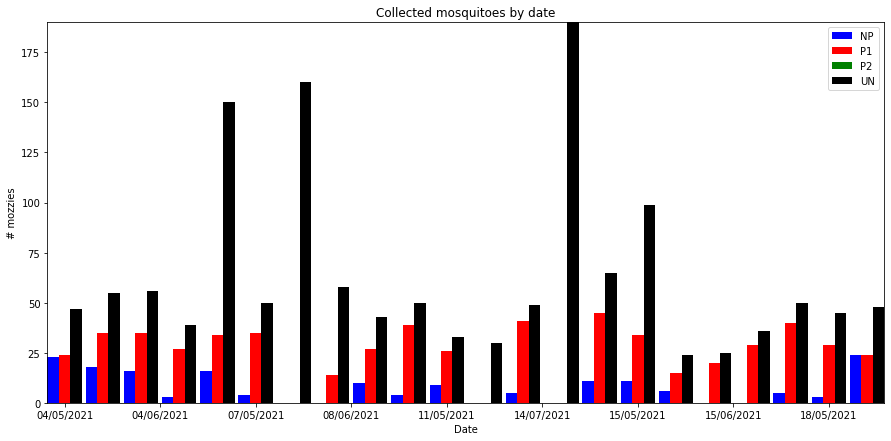

In [26]:
data_extract = wild_data_loader(species_choice='AA')

NP = data_extract.y_col_date[data_extract.y_age_groups==0]
P1 = data_extract.y_col_date[data_extract.y_age_groups==1]
P2 = data_extract.y_col_date[data_extract.y_age_groups==2]
UN = data_extract.y_col_date_vf[data_extract.y_age_groups_vf==99]

labels_w_counts = np.unique(UN, return_counts=True)
print(labels_w_counts)
labels = labels_w_counts[0]
labels_dict = {}
for i, lab in enumerate(labels):
    labels_dict[lab] = i
# print(labels_dict)
x = np.arange(len(labels))
width = 0.3

# print(x)

NP_vals = np.unique(NP, return_counts=True)
P1_vals = np.unique(P1, return_counts=True)
P2_vals = np.unique(P2, return_counts=True)
UN_vals = np.unique(UN, return_counts=True)

# print(NP_vals)
# print(P1_vals)
# print(P2_vals)

# print(NP)
fig, ax = plt.subplots(1,1, figsize =(15, 7))

x = []
for val in NP_vals[0]:
    x.append(labels_dict[val]-width)
ax.bar(x, NP_vals[1], width=width, color='blue', label='NP')

x = []
for val in P1_vals[0]:
    x.append(labels_dict[val])
ax.bar(x, P1_vals[1], width=width, color='red', label='P1')

x = []
for val in P2_vals[0]:
    x.append(labels_dict[val]+width)
ax.bar(x, P2_vals[1], width=width, color='green', label='P2')

x = []
for val in UN_vals[0]:
    x.append(labels_dict[val]+width)
ax.bar(x, UN_vals[1], width=width, color='black', label='UN')
# ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))
ax.margins(0)
# ax.set_xlim([18743, mdates.epoch2num(time.mktime(datetime.now().timetuple()))])
# ax.set_xlim([18743, 18810])
ax.set_title('Collected mosquitoes by date')
ax.set_ylabel('# mozzies')
ax.set_xlabel('Date')
ax.set_xticklabels(labels)
plt.legend()
plt.show()

blood fed with species AA : (0, 1633)
blood fed with species AC : (0, 1633)
(0, 1633)
(293, 1633)
Wild data shapes:
shape of X : (758, 1625)
shape of y age : (758,)
shape of y age groups : (758,)
shape of y age groups2 : (758,)
shape of y species : (758,)
shape of y status : (758,)
shape of y_age_groups_T : (758,)
shape of y_age_groups_B : (335,)
Status counts : (array(['NP', 'P1', 'P2', 'P3'], dtype=object), array([168, 573,  16,   1]))
Age groups counts : (array([0, 1, 2]), array([168, 573,  17]))
Species counts : (array(['AA'], dtype=object), array([758]))
shape of X_vf : (1402, 1625)
shape of X_vf_T : (834, 1625)
shape of X_vf_B : (568, 1625)
shape of y_age_vf age : (1402,)
shape of y_age_groups_vf age : (1402,)
shape of y y_species_vf : (1402,)
shape of y y_status_vf : (1402,)
Test age groups counts : (array([99]), array([1402]))
[23. 18. 16.  3. 16.  4.  0. 10.  4.  9.  5. 11. 11.  6.  0.  0.  5.  3.
 24.]
[24. 35. 35. 27. 34. 35. 14. 27. 39. 26. 41. 45. 34. 15. 20. 29. 40. 29.
 

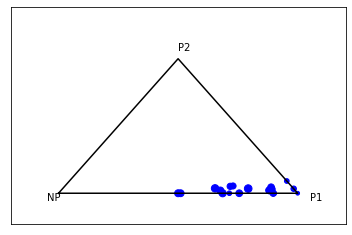

In [28]:
data_extract = wild_data_loader(species_choice='AA')

NP = data_extract.y_col_date[data_extract.y_age_groups==0]
P1 = data_extract.y_col_date[data_extract.y_age_groups==1]
P2 = data_extract.y_col_date[data_extract.y_age_groups==2]

labels_w_counts = np.unique(P1, return_counts=True)
# print(labels_w_counts)
labels = labels_w_counts[0]
labels_dict = {}
for i, lab in enumerate(labels):
    labels_dict[lab] = i
# print(labels_dict)
x = np.arange(len(labels))
width = 0.3

# print(x)

NP_vals = np.unique(NP, return_counts=True)
P1_vals = np.unique(P1, return_counts=True)
P2_vals = np.unique(P2, return_counts=True)

NP_ratios = []
P1_ratios = []
P2_ratios = []
for lab in labels:
    if lab in NP_vals[0]:
        NP_temp = float(NP_vals[1][np.where(NP_vals[0]==lab)])
    else:
        NP_temp = 0
    if lab in P2_vals[0]:
        P2_temp = float(P2_vals[1][np.where(P2_vals[0]==lab)])
    else:
        P2_temp = 0
    P1_temp = float(P1_vals[1][np.where(P1_vals[0]==lab)])
    NP_ratios.append(NP_temp)
    P1_ratios.append(P1_temp)
    P2_ratios.append(P2_temp)
NP_ratios = np.asarray(NP_ratios)
P1_ratios = np.asarray(P1_ratios)
P2_ratios = np.asarray(P2_ratios)
print(NP_ratios)
print(P1_ratios)
print(P2_ratios)

ratio_sums = np.concatenate((np.reshape(NP_ratios, (1,-1)),
                             np.reshape(P1_ratios, (1,-1)),
                             np.reshape(P2_ratios, (1,-1))), axis=0)
ratio_sums = np.sum(ratio_sums, axis=0)
print(ratio_sums)

NP_ratios = NP_ratios/ratio_sums
P1_ratios = P1_ratios/ratio_sums
P2_ratios = P2_ratios/ratio_sums
print(NP_ratios)
print(P1_ratios)
print(P2_ratios)

ratios = np.concatenate((np.reshape(NP_ratios, (-1,1)),
                             np.reshape(P1_ratios, (-1,1)),
                             np.reshape(P2_ratios, (-1,1))), axis=1)
print(ratios.shape)

fig = plotSimplex(ratios, vertexlabels=['NP','P1','P2'], weights=ratio_sums)
plt.show()

# fig, ax = plt.subplots(1,1, figsize =(15, 7))

# ax.boxplot([NP_ratios, P1_ratios, P2_ratios])
# # ax.boxplot(P1_ratios)
# # ax.boxplot(P2_ratios)

# ax.set_xticklabels([f'NP ratio', f'P1 ratio', f'P2 ratio'])
# ax.set_yticks(np.arange(10)/10)
# ax.grid()
# # plt.legend()
# plt.show()

blood fed with species AA : (0, 1633)
blood fed with species AC : (0, 1633)
(0, 1633)
(293, 1633)
Wild data shapes:
shape of X : (335, 1625)
shape of y age : (335,)
shape of y age groups : (335,)
shape of y age groups2 : (335,)
shape of y species : (335,)
shape of y status : (335,)
shape of y_age_groups_T : (758,)
shape of y_age_groups_B : (335,)
Status counts : (array(['NP', 'P1', 'P2', 'P3'], dtype=object), array([205, 104,  20,   6]))
Age groups counts : (array([0, 1, 2]), array([205, 104,  26]))
Species counts : (array(['AC'], dtype=object), array([335]))
shape of X_vf : (1402, 1625)
shape of X_vf_T : (834, 1625)
shape of X_vf_B : (568, 1625)
shape of y_age_vf age : (1402,)
shape of y_age_groups_vf age : (1402,)
shape of y y_species_vf : (1402,)
shape of y y_status_vf : (1402,)
Test age groups counts : (array([99]), array([1402]))
[ 55. 101.   7.   8.  24.   1.   9.]
[25. 29.  2.  2. 41.  2.  3.]
[ 6.  2.  2.  2. 12.  0.  2.]
[ 86. 132.  11.  12.  77.   3.  14.]
[0.63953488 0.76515

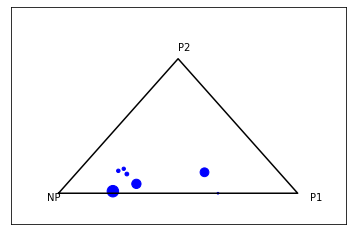

In [29]:
data_extract = wild_data_loader(species_choice='AC')

NP = data_extract.y_col_date[data_extract.y_age_groups==0]
P1 = data_extract.y_col_date[data_extract.y_age_groups==1]
P2 = data_extract.y_col_date[data_extract.y_age_groups==2]

labels_w_counts = np.unique(P1, return_counts=True)
# print(labels_w_counts)
labels = labels_w_counts[0]
labels_dict = {}
for i, lab in enumerate(labels):
    labels_dict[lab] = i
# print(labels_dict)
x = np.arange(len(labels))
width = 0.3

# print(x)

NP_vals = np.unique(NP, return_counts=True)
P1_vals = np.unique(P1, return_counts=True)
P2_vals = np.unique(P2, return_counts=True)

NP_ratios = []
P1_ratios = []
P2_ratios = []
for lab in labels:
    if lab in NP_vals[0]:
        NP_temp = float(NP_vals[1][np.where(NP_vals[0]==lab)])
    else:
        NP_temp = 0
    if lab in P2_vals[0]:
        P2_temp = float(P2_vals[1][np.where(P2_vals[0]==lab)])
    else:
        P2_temp = 0
    P1_temp = float(P1_vals[1][np.where(P1_vals[0]==lab)])
    NP_ratios.append(NP_temp)
    P1_ratios.append(P1_temp)
    P2_ratios.append(P2_temp)
NP_ratios = np.asarray(NP_ratios)
P1_ratios = np.asarray(P1_ratios)
P2_ratios = np.asarray(P2_ratios)
print(NP_ratios)
print(P1_ratios)
print(P2_ratios)

ratio_sums = np.concatenate((np.reshape(NP_ratios, (1,-1)),
                             np.reshape(P1_ratios, (1,-1)),
                             np.reshape(P2_ratios, (1,-1))), axis=0)
ratio_sums = np.sum(ratio_sums, axis=0)
print(ratio_sums)

NP_ratios = NP_ratios/ratio_sums
P1_ratios = P1_ratios/ratio_sums
P2_ratios = P2_ratios/ratio_sums
print(NP_ratios)
print(P1_ratios)
print(P2_ratios)

ratios = np.concatenate((np.reshape(NP_ratios, (-1,1)),
                             np.reshape(P1_ratios, (-1,1)),
                             np.reshape(P2_ratios, (-1,1))), axis=1)
print(ratios.shape)

fig = plotSimplex(ratios, vertexlabels=['NP','P1','P2'], weights=ratio_sums)
plt.show()

# fig, ax = plt.subplots(1,1, figsize =(15, 7))

# ax.boxplot([NP_ratios, P1_ratios, P2_ratios])
# # ax.boxplot(P1_ratios)
# # ax.boxplot(P2_ratios)

# ax.set_xticklabels([f'NP ratio', f'P1 ratio', f'P2 ratio'])
# ax.set_yticks(np.arange(10)/10)
# ax.grid()
# # plt.legend()
# plt.show()

## Train model for AA

In [28]:
## Name a folder for the outputs to go into
outdir = "Results_Paper/"
build_folder(outdir, False)

savedir = (outdir+"Test_Wild_LabField_Model_v2_NP_P1_P234_AA/")
build_folder(savedir, False)

Testing = False

val_results = {'loss':[], 
               'age_group_loss':[], 
               'species_loss':[], 
               'age_group_acc':[], 
               'species_acc':[]}

start_time = time()

data_extract_old = data_loader_class()
data_extract = wild_data_loader(species_choice='AA')
# print(f'data_extract info X : {data_extract.X}')

## Input CNN Size
#         input_layer_dim = len(data_extract.X[0])

y_age_groups_list = [[age] for age in data_extract.y_age_groups]
y_species_list = [[species] for species in data_extract.y_species]
# age_groups_MLB = MultiLabelBinarizer().fit(np.array(y_age_groups_list))
age_groups = MultiLabelBinarizer().fit_transform(np.array(y_age_groups_list))
age_group_classes = ["1-4", "5-10", "11-17"]
species = MultiLabelBinarizer().fit_transform(np.array(y_species_list))
species_classes = ["AA", "AC"]
# species_classes = list(np.unique(y_species_list))
# y_age_groups_list_vf = [[age] for age in data_extract.y_age_groups_vf]
# y_species_list_vf = [[species] for species in data_extract.y_species_vf]
# age_groups_vf = age_groups_MLB.transform(np.array(y_age_groups_list_vf))
# species_vf = MultiLabelBinarizer().fit_transform(np.array(y_species_list_vf))

## Labels
labels_default, classes_default, outputs_default = [age_groups], [age_group_classes], ['xAgeGroup']
# labels_default, classes_default, outputs_default = [age_groups, species], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']
# labels_default_vf, classes_default_vf, outputs_default_vf = [age_groups_vf, species_vf], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']

## Declare and train the model
model_size = [{'type':'c', 'filter':16, 'kernel':8, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':8, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':3, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':6, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2},
             {'type':'d', 'width':500}]

## Name the model
model_name = ('Wild-Model')

## Scale train, test
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((data_extract.X, data_extract.X_vf)))
X_train = features_scl.transform(X=data_extract.X)
X_test = features_scl.transform(X=data_extract.X_vf)
X_test_T = features_scl.transform(X=data_extract.X_vf_T)
# X_test_B = features_scl.transform(X=data_extract.X_vf_B)

## Split data into test and train
# y_train, y_test = list(map(lambda y:y, labels_default)), list(map(lambda y:y, labels_default_vf))
y_train = list(map(lambda y:y, labels_default))

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_test_T = np.expand_dims(X_test_T, axis=2)
# X_test_B = np.expand_dims(X_test_B, axis=2)


Original lab/field data shapes:
shape of X : (4800, 1625)
shape of y age : (4800,)
shape of y age groups : (4800,)
shape of y species : (4800,)
shape of y status : (4800,)
blood fed with species AA : (0, 1633)
blood fed with species AC : (0, 1633)
(0, 1633)
(293, 1633)
Wild data shapes:
shape of X : (758, 1625)
shape of y age : (758,)
shape of y age groups : (758,)
shape of y age groups2 : (758,)
shape of y species : (758,)
shape of y status : (758,)
shape of y_age_groups_T : (758,)
shape of y_age_groups_B : (335,)
Status counts : (array(['NP', 'P1', 'P2', 'P3'], dtype=object), array([168, 573,  16,   1]))
Age groups counts : (array([0, 1, 2]), array([168, 573,  17]))
Species counts : (array(['AA'], dtype=object), array([758]))
shape of X_vf : (1402, 1625)
shape of X_vf_T : (834, 1625)
shape of X_vf_B : (568, 1625)
shape of y_age_vf age : (1402,)
shape of y_age_groups_vf age : (1402,)
shape of y y_species_vf : (1402,)
shape of y y_status_vf : (1402,)
Test age groups counts : (array([99

In [83]:
model_to_test = {
        "model_shape" : [model_size], # defines the hidden layers of the model
        "model_name"  : [model_name],
#             "input_layer_dim"  : [input_layer_dim], # size of input layer
        "model_ver_num"  : [0],
        "fold"  : [0], # kf.split number on
        "labels"   : [y_train],
        "features" : [X_train],
        "classes"  : [classes_default],
        "outputs"   : [outputs_default],
        "compile_loss": [{'age': 'categorical_crossentropy'}],
        "compile_metrics" :[{'age': 'accuracy'}]
    }                

class_weight = np.unique(data_extract.y_age_groups, return_counts=True)[1]
class_weight = {0:np.max(class_weight)/class_weight[0],
                 1:np.max(class_weight)/class_weight[1],
                 2:np.max(class_weight)/class_weight[2]}
#                  3:np.max(class_weight)/class_weight[3]}
print(class_weight)

## Call function to train all the models from the dictionary
if Testing:
    model = load_only_models()
else:
#     model, history, data_out = train_models(model_to_test, savedir, wild=True, class_weight=class_weight, cv=10, num_classes=3, species=False)
    model, history, data_out = train_models(model_to_test, savedir, wild=True, class_weight=None, cv=10, num_classes=3, species=False)


# predicted_labels = list([] for i in range(len(y_train)))
# true_labels = list([] for i in range(len(y_train)))

# y_predicted = model.predict(X_test)
# print(y_predicted)

end_time = time()
print('Run time : {} s'.format(end_time-start_time))
print('Run time : {} m'.format((end_time-start_time)/60))
print('Run time : {} h'.format((end_time-start_time)/3600))



{0: 3.4107142857142856, 1: 1.0, 2: 33.705882352941174}
(758, 1625, 1)
input : False
Conv1 : False
batchnorm_1 : False
max_pooling1d_56 : False
Conv2 : False
batchnorm_2 : False
max_pooling1d_57 : False
Conv3 : False
batchnorm_3 : False
max_pooling1d_58 : False
Conv4 : False
batchnorm_4 : False
max_pooling1d_59 : False
Conv5 : False
batchnorm_5 : False
max_pooling1d_60 : False
flatten_12 : False
dout6 : True
d_wild : True
batchnorm_wild : True
age_group : True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1625, 1)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1618, 16)          144       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 1618, 16)          64        
_________________________________________________________________
max_pool

76/76 [==============================] - 0s 131us/step
input : False
Conv1 : False
batchnorm_1 : False
max_pooling1d_56 : False
Conv2 : False
batchnorm_2 : False
max_pooling1d_57 : False
Conv3 : False
batchnorm_3 : False
max_pooling1d_58 : False
Conv4 : False
batchnorm_4 : False
max_pooling1d_59 : False
Conv5 : False
batchnorm_5 : False
max_pooling1d_60 : False
flatten_12 : False
dout6 : True
d_wild : True
batchnorm_wild : True
age_group : True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1625, 1)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1618, 16)          144       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 1618, 16)          64        
_________________________________________________________________
max_pooling1d_56 (MaxPo

76/76 [==============================] - 0s 120us/step
input : False
Conv1 : False
batchnorm_1 : False
max_pooling1d_56 : False
Conv2 : False
batchnorm_2 : False
max_pooling1d_57 : False
Conv3 : False
batchnorm_3 : False
max_pooling1d_58 : False
Conv4 : False
batchnorm_4 : False
max_pooling1d_59 : False
Conv5 : False
batchnorm_5 : False
max_pooling1d_60 : False
flatten_12 : False
dout6 : True
d_wild : True
batchnorm_wild : True
age_group : True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1625, 1)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1618, 16)          144       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 1618, 16)          64        
_________________________________________________________________
max_pooling1d_56 (MaxPo

75/75 [==============================] - 0s 141us/step
input : False
Conv1 : False
batchnorm_1 : False
max_pooling1d_56 : False
Conv2 : False
batchnorm_2 : False
max_pooling1d_57 : False
Conv3 : False
batchnorm_3 : False
max_pooling1d_58 : False
Conv4 : False
batchnorm_4 : False
max_pooling1d_59 : False
Conv5 : False
batchnorm_5 : False
max_pooling1d_60 : False
flatten_12 : False
dout6 : True
d_wild : True
batchnorm_wild : True
age_group : True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1625, 1)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1618, 16)          144       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 1618, 16)          64        
_________________________________________________________________
max_pooling1d_56 (MaxPo

In [19]:
num_classes = 3

In [20]:
load = True
if load:
    model = []
    for i in range(10):
        m1 = load_model(f'Results_Paper/Test_Wild_LabField_Model_v2_NP_P1_P234_AA/Wild-Model_{i}.h5')
        model.append(m1)

In [35]:
true_means = np.array([0.2713615,0.7070423,0.02159624])
ci95lower = np.array([0.2450826,0.6793604,0.01375120])
ci95upper = np.array([0.2984537,0.7339876,0.03113818])

## Plots with model argmax predicitons

Results for model 0
Results for model 1
Results for model 2
Results for model 3
Results for model 4
Results for model 5
Results for model 6
Results for model 7
Results for model 8
Results for model 9
[ 494 7846]
[0.05923261 0.94076739]
[0.22163588 0.75593668 0.02242744]


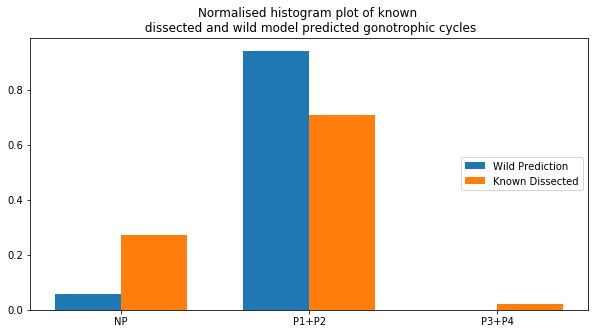

In [32]:
y_pred_vals_raw = np.empty((0,num_classes))
y_pred_vals = np.empty((0,))
y_pred_counts_out_raw = np.empty((0,num_classes))
y_pred_counts_out = np.empty((0,num_classes))
for i in range(10):
    print(f'Results for model {i}')
    m1 = model[i]

    y_predicted = m1.predict(X_test_T)
#     print(y_predicted.shape)
#     y_predicted = np.expand_dims(y_predicted[0], axis=0)
#     print(y_pred_vals_raw.shape)
#     print(y_predicted.shape)
    y_pred_vals_raw = np.append(y_pred_vals_raw, y_predicted, axis=0)
#     y_pred_vals = np.argmax(y_predicted, -1)
    y_pred_vals = np.append(y_pred_vals, np.argmax(y_predicted, -1))
    y_pred_count = np.unique(np.argmax(y_predicted, -1), return_counts=True)[1]
    if y_pred_count.shape[0] == num_classes-2:
        y_pred_count = np.append(y_pred_count, 0)
        y_pred_count = np.append(y_pred_count, 0)
        y_pred_count = y_pred_count.reshape(1,num_classes)
    elif y_pred_count.shape[0] == num_classes-1:
        y_pred_count = np.append(y_pred_count, 0)
        y_pred_count = y_pred_count.reshape(1,num_classes)
    else:
        y_pred_count = y_pred_count.reshape(1,num_classes)
    y_pred_counts_out_raw = np.append(y_pred_counts_out_raw, y_pred_count, axis=0)
    y_pred_counts_out = np.append(y_pred_counts_out, y_pred_count/np.sum(y_pred_count), axis=0)
    
#     print(np.unique(y_pred_vals, return_counts=True)[1])
#     print(np.unique(data_extract.y_age_groups, return_counts=True)[1])

# fig = plt.figure(figsize=(10,5))
# plt.title(f'Histogram plot of known dissected \n and wild model predicted gonotrophic cycles')

# plt.hist([y_pred_vals, data_extract.y_age_groups], label=['Wild Prediction', 'Known Dissected'])
# plt.xticks([0,1,2], ['NP', 'P1+P2', 'P3+P4'])
# plt.legend(loc='right')
# plt.show()

    # print(np.argmax(y_predicted, -1))
    # print(data_extract.y_age_groups)
fig = plt.figure(figsize=(10,5))
plt.title(f'Normalised histogram plot of known \n dissected and wild model predicted gonotrophic cycles')

y_pred_counts = np.unique(y_pred_vals, return_counts=True)[1]
print(y_pred_counts)
y_pred_counts = y_pred_counts/np.sum(y_pred_counts)
print(y_pred_counts)

# print(y_pred_vals_raw.shape)
# y_pred_counts = np.mean(y_pred_vals_raw, axis=0)

y_true_counts = np.unique(data_extract.y_age_groups, return_counts=True)[1]
y_true_counts = y_true_counts/np.sum(y_true_counts)
print(y_true_counts)
width = 0.35
if len(y_pred_counts) == num_classes:
    widths = [i-width/2 for i in range(num_classes)]
elif len(y_pred_counts) == num_classes-1:
    widths = [i-width/2 for i in range(num_classes-1)]
else:
    widths = [0-width/2,1-width/2]
plt.bar(widths, y_pred_counts, width=width, label='Wild Prediction')
if num_classes == 4:
    plt.bar([0+width/2,1+width/2,2+width/2,3+width/2], y_true_counts, width=width, label='Known Dissected')
    plt.xticks([0,1,2,3], ['NP', 'P1', 'P2', 'P3+P4'])
elif num_classes == 3:
    plt.bar([0+width/2,1+width/2,2+width/2], true_means, width=width, label='Known Dissected')
    plt.xticks([0,1,2], ['NP', 'P1+P2', 'P3+P4'])

plt.legend(loc='right')
# plt.savefig(f'{savedir}bar.png')
plt.show()

#     print(y_pred_counts-y_true_counts)

(8340, 3)
[0.22163588 0.75593668 0.02242744]
[[0.10436211 0.87566554 0.01997236]
 [0.10055757 0.87842095 0.02102148]
 [0.09364072 0.89065137 0.01570791]
 [0.08568282 0.89616789 0.01814929]
 [0.1042318  0.87777692 0.01799128]
 [0.11446416 0.86980221 0.01573363]
 [0.12187646 0.8563923  0.02173124]
 [0.10265067 0.87780226 0.01954707]
 [0.10258607 0.87909773 0.0183162 ]
 [0.09650628 0.88436409 0.01912963]]


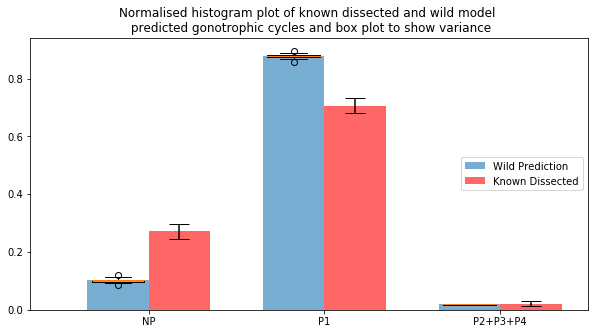

In [37]:
fig = plt.figure(figsize=(10,5))
plt.title(f'Normalised histogram plot of known dissected and wild model \n predicted gonotrophic cycles and box plot to show variance')

# y_pred_counts = np.unique(y_pred_vals, return_counts=True)[1]
# y_pred_counts = y_pred_counts/np.sum(y_pred_counts)
# print(y_pred_counts.shape)

print(y_pred_vals_raw.shape)
y_pred_counts = np.mean(y_pred_vals_raw, axis=0)

y_true_counts = np.unique(data_extract.y_age_groups, return_counts=True)[1]
y_true_counts = y_true_counts/np.sum(y_true_counts)
print(y_true_counts)
width = 0.35
if len(y_pred_counts) == num_classes:
    widths = [i-width/2 for i in range(num_classes)]
elif len(y_pred_counts) == num_classes-1:
    widths = [i-width/2 for i in range(num_classes-1)]
else:
    widths = [0-width/2,1-width/2]
plt.bar(widths, y_pred_counts, width=width, label='Wild Prediction', alpha=0.6)
# if num_classes == 4:
#     plt.bar([0+width/2,1+width/2,2+width/2,3+width/2], y_true_counts, width=width, label='Known Dissected', color='red', alpha=0.6)
# elif num_classes == 3:
#     plt.bar([0+width/2,1+width/2,2+width/2], y_true_counts, width=width, label='Known Dissected', color='red', alpha=0.6)
plt.bar([0+width/2,1+width/2,2+width/2], true_means, yerr=ci95upper-true_means, width=width, label='Known Dissected', color='red', alpha=0.6, capsize=10)
 
y_pred_vals_raw_out = np.reshape(y_pred_vals_raw, (10,-1,3))
y_pred_counts_out = np.mean(y_pred_vals_raw_out, axis=1)
print(y_pred_counts_out)
plt.boxplot(y_pred_counts_out[:,:], positions=[0-width/2,1-width/2,2-width/2])

if num_classes == 4:
    plt.xticks([0,1,2,3], ['NP', 'P1','P2', 'P3+P4'])
elif num_classes == 3:
#     plt.xticks([0,1,2], ['NP', 'P1+P2', 'P3+P4'])
    plt.xticks([0,1,2], ['NP', 'P1', 'P2+P3+P4'])

plt.legend(loc='right')
plt.savefig(f'{savedir}bar_and_hist_model_probs.png', facecolor=fig.get_facecolor())
plt.show()


(834000, 3)
(3,)
[0.1022482  0.87892926 0.01882254]
[0.09179351 0.10641262 0.01846825]


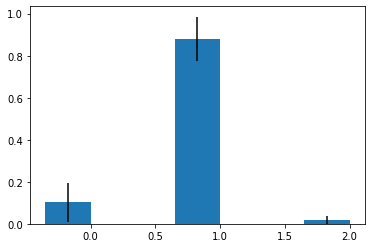

In [39]:
y_pred_sample = np.empty((0,num_classes))
for sample in y_pred_vals_raw:
#     print(np.random.multinomial(n=1, pvals=sample, size=10).shape)
    y_pred_sample = np.append(y_pred_sample, np.random.multinomial(n=1, pvals=sample, size=100), axis=0)
print(y_pred_sample.shape)

y_pred_sample_mean = np.sum(y_pred_sample, axis=0)
y_pred_sample_mean = y_pred_sample_mean/np.sum(y_pred_sample_mean)
print(y_pred_sample_mean.shape)
print(y_pred_sample_mean)

y_pred_sample_var = np.var(y_pred_sample, axis=0)
print(y_pred_sample_var)

width = 0.35
widths = [i-width/2 for i in range(num_classes)]
plt.bar(widths, y_pred_sample_mean, yerr=y_pred_sample_var, width=width, label='Wild Prediction')
plt.show()

(8340, 3)
[0.22163588 0.75593668 0.02242744]
(834000, 3)
(10, 834, 100, 3)
(10, 100, 3)
(1000, 3)


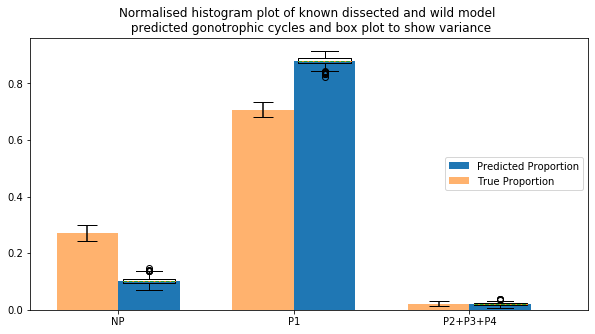

In [45]:
fig = plt.figure(figsize=(10,5))
plt.title(f'Normalised histogram plot of known dissected and wild model \n predicted gonotrophic cycles and box plot to show variance')

# y_pred_counts = np.unique(y_pred_vals, return_counts=True)[1]
# y_pred_counts = y_pred_counts/np.sum(y_pred_counts)
# print(y_pred_counts.shape)

print(y_pred_vals_raw.shape)
y_pred_counts = np.mean(y_pred_vals_raw, axis=0)

y_true_counts = np.unique(data_extract.y_age_groups, return_counts=True)[1]
y_true_counts = y_true_counts/np.sum(y_true_counts)
print(y_true_counts)
width = 0.35
if len(y_pred_counts) == num_classes:
    widths = [i+width/2 for i in range(num_classes)]
elif len(y_pred_counts) == num_classes-1:
    widths = [i+width/2 for i in range(num_classes-1)]
else:
    widths = [0+width/2,1+width/2]
plt.bar(widths, y_pred_sample_mean, width=width, label='Predicted Proportion', color='tab:blue')

# if num_classes == 4:
#     plt.bar([0+width/2,1+width/2,2+width/2,3+width/2], y_true_counts, width=width, label='Known Dissected', color='red', alpha=0.6)
# elif num_classes == 3:
#     plt.bar([0+width/2,1+width/2,2+width/2], y_true_counts, width=width, label='Known Dissected', color='red', alpha=0.6)
plt.bar([0-width/2,1-width/2,2-width/2], true_means, yerr=ci95upper-true_means, width=width, label='True Proportion', color='tab:orange', alpha=0.6, capsize=10)
 
y_pred_vals_raw_out = np.reshape(y_pred_vals_raw, (10,-1,3))
y_pred_counts_out = np.mean(y_pred_vals_raw_out, axis=1)
print(y_pred_sample.shape)
y_pred_sample_box = np.reshape(y_pred_sample, (10,834,100,3))
print(y_pred_sample_box.shape)
y_pred_sample_box = np.mean(y_pred_sample_box, axis=1)
print(y_pred_sample_box.shape)
y_pred_sample_box = np.reshape(y_pred_sample_box, (1000,3))
np.savetxt(f'{savedir}bar_and_hist_model_sample.txt', y_pred_sample_box)
print(y_pred_sample_box.shape)
plt.boxplot(y_pred_sample_box, positions=[0+width/2,1+width/2,2+width/2], meanline=True, showmeans=True)

if num_classes == 4:
    plt.xticks([0,1,2,3], ['NP', 'P1','P2', 'P3+P4'])
elif num_classes == 3:
#     plt.xticks([0,1,2], ['NP', 'P1+P2', 'P3+P4'])
    plt.xticks([0,1,2], ['NP', 'P1', 'P2+P3+P4'])

plt.legend(loc='right')
fig.patch.set_facecolor('xkcd:white')
plt.savefig(f'{savedir}bar_and_hist_model_sample.png', facecolor=fig.get_facecolor())
plt.show()




## Train model for AC

In [46]:
## Name a folder for the outputs to go into
outdir = "Results_Paper/"
build_folder(outdir, False)

savedir = (outdir+"Test_Wild_LabField_Model_v2_NP_P1_P234_AC/")
build_folder(savedir, False)

Testing = False

val_results = {'loss':[], 
               'age_group_loss':[], 
               'species_loss':[], 
               'age_group_acc':[], 
               'species_acc':[]}

start_time = time()

data_extract_old = data_loader_class()
data_extract = wild_data_loader(species_choice='AC')
# print(f'data_extract info X : {data_extract.X}')

## Input CNN Size
#         input_layer_dim = len(data_extract.X[0])

y_age_groups_list = [[age] for age in data_extract.y_age_groups]
y_species_list = [[species] for species in data_extract.y_species]
# age_groups_MLB = MultiLabelBinarizer().fit(np.array(y_age_groups_list))
age_groups = MultiLabelBinarizer().fit_transform(np.array(y_age_groups_list))
age_group_classes = ["1-4", "5-10", "11-17"]
species = MultiLabelBinarizer().fit_transform(np.array(y_species_list))
species_classes = ["AA", "AC"]
# species_classes = list(np.unique(y_species_list))
# y_age_groups_list_vf = [[age] for age in data_extract.y_age_groups_vf]
# y_species_list_vf = [[species] for species in data_extract.y_species_vf]
# age_groups_vf = age_groups_MLB.transform(np.array(y_age_groups_list_vf))
# species_vf = MultiLabelBinarizer().fit_transform(np.array(y_species_list_vf))

## Labels
labels_default, classes_default, outputs_default = [age_groups], [age_group_classes], ['xAgeGroup']
# labels_default, classes_default, outputs_default = [age_groups, species], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']
# labels_default_vf, classes_default_vf, outputs_default_vf = [age_groups_vf, species_vf], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']

## Declare and train the model
model_size = [{'type':'c', 'filter':16, 'kernel':8, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':8, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':3, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':6, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2},
             {'type':'d', 'width':500}]

## Name the model
model_name = ('Wild-Model')

## Scale train, test
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((data_extract.X, data_extract.X_vf)))
X_train = features_scl.transform(X=data_extract.X)
X_test = features_scl.transform(X=data_extract.X_vf)
# X_test_T = features_scl.transform(X=data_extract.X_vf_T)
X_test_B = features_scl.transform(X=data_extract.X_vf_B)

## Split data into test and train
# y_train, y_test = list(map(lambda y:y, labels_default)), list(map(lambda y:y, labels_default_vf))
y_train = list(map(lambda y:y, labels_default))

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
# X_test_T = np.expand_dims(X_test_T, axis=2)
X_test_B = np.expand_dims(X_test_B, axis=2)
print(f'X_test shape : {X_test.shape}')
# print(f'X_test_T shape : {X_test_T.shape}')
print(f'X_test_B shape : {X_test_B.shape}')


Original lab/field data shapes:
shape of X : (4800, 1625)
shape of y age : (4800,)
shape of y age groups : (4800,)
shape of y species : (4800,)
shape of y status : (4800,)
blood fed with species AA : (0, 1633)
blood fed with species AC : (0, 1633)
(0, 1633)
(293, 1633)
Wild data shapes:
shape of X : (335, 1625)
shape of y age : (335,)
shape of y age groups : (335,)
shape of y age groups2 : (335,)
shape of y species : (335,)
shape of y status : (335,)
shape of y_age_groups_T : (758,)
shape of y_age_groups_B : (335,)
Status counts : (array(['NP', 'P1', 'P2', 'P3'], dtype=object), array([205, 104,  20,   6]))
Age groups counts : (array([0, 1, 2]), array([205, 104,  26]))
Species counts : (array(['AC'], dtype=object), array([335]))
shape of X_vf : (1402, 1625)
shape of X_vf_T : (834, 1625)
shape of X_vf_B : (568, 1625)
shape of y_age_vf age : (1402,)
shape of y_age_groups_vf age : (1402,)
shape of y y_species_vf : (1402,)
shape of y y_status_vf : (1402,)
Test age groups counts : (array([99

In [33]:
model_to_test = {
        "model_shape" : [model_size], # defines the hidden layers of the model
        "model_name"  : [model_name],
#             "input_layer_dim"  : [input_layer_dim], # size of input layer
        "model_ver_num"  : [0],
        "fold"  : [0], # kf.split number on
        "labels"   : [y_train],
        "features" : [X_train],
        "classes"  : [classes_default],
        "outputs"   : [outputs_default],
        "compile_loss": [{'age': 'categorical_crossentropy'}],
        "compile_metrics" :[{'age': 'accuracy'}]
    }                

class_weight = np.unique(data_extract.y_age_groups, return_counts=True)[1]
class_weight = {0:np.max(class_weight)/class_weight[0],
                 1:np.max(class_weight)/class_weight[1],
                 2:np.max(class_weight)/class_weight[2]}
#                  3:np.max(class_weight)/class_weight[3]}
print(class_weight)

## Call function to train all the models from the dictionary
if Testing:
    model = load_only_models()
else:
    model, history, data_out = train_models(model_to_test, savedir, wild=True, class_weight=class_weight, cv=10, num_classes=3, species=False)


# predicted_labels = list([] for i in range(len(y_train)))
# true_labels = list([] for i in range(len(y_train)))

# y_predicted = model.predict(X_test)
# print(y_predicted)

end_time = time()
print('Run time : {} s'.format(end_time-start_time))
print('Run time : {} m'.format((end_time-start_time)/60))
print('Run time : {} h'.format((end_time-start_time)/3600))



{0: 1.0, 1: 1.9711538461538463, 2: 7.884615384615385}
(335, 1625, 1)
input : False
Conv1 : False
batchnorm_1 : False
max_pooling1d_56 : False
Conv2 : False
batchnorm_2 : False
max_pooling1d_57 : False
Conv3 : False
batchnorm_3 : False
max_pooling1d_58 : False
Conv4 : False
batchnorm_4 : False
max_pooling1d_59 : False
Conv5 : False
batchnorm_5 : False
max_pooling1d_60 : False
flatten_12 : False
dout6 : True
d_wild : True
batchnorm_wild : True
age_group : True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1625, 1)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1618, 16)          144       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 1618, 16)          64        
_________________________________________________________________
max_pooli

34/34 [==============================] - 0s 126us/step
input : False
Conv1 : False
batchnorm_1 : False
max_pooling1d_56 : False
Conv2 : False
batchnorm_2 : False
max_pooling1d_57 : False
Conv3 : False
batchnorm_3 : False
max_pooling1d_58 : False
Conv4 : False
batchnorm_4 : False
max_pooling1d_59 : False
Conv5 : False
batchnorm_5 : False
max_pooling1d_60 : False
flatten_12 : False
dout6 : True
d_wild : True
batchnorm_wild : True
age_group : True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1625, 1)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1618, 16)          144       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 1618, 16)          64        
_________________________________________________________________
max_pooling1d_56 (MaxPo

33/33 [==============================] - 0s 148us/step
input : False
Conv1 : False
batchnorm_1 : False
max_pooling1d_56 : False
Conv2 : False
batchnorm_2 : False
max_pooling1d_57 : False
Conv3 : False
batchnorm_3 : False
max_pooling1d_58 : False
Conv4 : False
batchnorm_4 : False
max_pooling1d_59 : False
Conv5 : False
batchnorm_5 : False
max_pooling1d_60 : False
flatten_12 : False
dout6 : True
d_wild : True
batchnorm_wild : True
age_group : True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1625, 1)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1618, 16)          144       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 1618, 16)          64        
_________________________________________________________________
max_pooling1d_56 (MaxPo

33/33 [==============================] - 0s 116us/step
input : False
Conv1 : False
batchnorm_1 : False
max_pooling1d_56 : False
Conv2 : False
batchnorm_2 : False
max_pooling1d_57 : False
Conv3 : False
batchnorm_3 : False
max_pooling1d_58 : False
Conv4 : False
batchnorm_4 : False
max_pooling1d_59 : False
Conv5 : False
batchnorm_5 : False
max_pooling1d_60 : False
flatten_12 : False
dout6 : True
d_wild : True
batchnorm_wild : True
age_group : True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1625, 1)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1618, 16)          144       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 1618, 16)          64        
_________________________________________________________________
max_pooling1d_56 (MaxPo

In [47]:
num_classes = 3

In [49]:
load = True
if load:
    model = []
    for i in range(10):
        m1 = load_model(f'Results_Paper/Test_Wild_LabField_Model_v2_NP_P1_P234_AC/Wild-Model_{i}.h5')
        model.append(m1)

In [50]:
true_means = np.array([0.6112760,0.3056380,0.08308605])
ci95lower = np.array([0.5587187,0.2576586,0.05608780])
ci95upper = np.array([0.6625821,0.3558025,0.11476279])

Results for model 0
Results for model 1
Results for model 2
Results for model 3
Results for model 4
Results for model 5
Results for model 6
Results for model 7
Results for model 8
Results for model 9
[4072 1563   45]
[0.71690141 0.27517606 0.00792254]
[0.6119403  0.31044776 0.07761194]


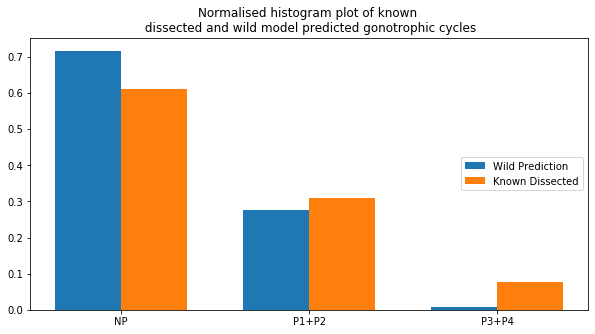

In [51]:
y_pred_vals_raw = np.empty((0,num_classes))
y_pred_vals = np.empty((0,))
y_pred_counts_out_raw = np.empty((0,num_classes))
y_pred_counts_out = np.empty((0,num_classes))
for i in range(10):
    print(f'Results for model {i}')
    m1 = model[i]

    y_predicted = m1.predict(X_test_B)
#     print(y_predicted.shape)
#     y_predicted = np.expand_dims(y_predicted[0], axis=0)
#     print(y_pred_vals_raw.shape)
#     print(y_predicted.shape)
    y_pred_vals_raw = np.append(y_pred_vals_raw, y_predicted, axis=0)
#     y_pred_vals = np.argmax(y_predicted, -1)
    y_pred_vals = np.append(y_pred_vals, np.argmax(y_predicted, -1))
    y_pred_count = np.unique(np.argmax(y_predicted, -1), return_counts=True)[1]
    if y_pred_count.shape[0] == num_classes-2:
        y_pred_count = np.append(y_pred_count, 0)
        y_pred_count = np.append(y_pred_count, 0)
        y_pred_count = y_pred_count.reshape(1,num_classes)
    elif y_pred_count.shape[0] == num_classes-1:
        y_pred_count = np.append(y_pred_count, 0)
        y_pred_count = y_pred_count.reshape(1,num_classes)
    else:
        y_pred_count = y_pred_count.reshape(1,num_classes)
    y_pred_counts_out_raw = np.append(y_pred_counts_out_raw, y_pred_count, axis=0)
#     print(y_pred_count)
    y_pred_counts_out = np.append(y_pred_counts_out, y_pred_count/np.sum(y_pred_count), axis=0)
    
#     print(np.unique(y_pred_vals, return_counts=True)[1])
#     print(np.unique(data_extract.y_age_groups, return_counts=True)[1])

# fig = plt.figure(figsize=(10,5))
# plt.title(f'Histogram plot of known dissected \n and wild model predicted gonotrophic cycles')

# plt.hist([y_pred_vals, data_extract.y_age_groups], label=['Wild Prediction', 'Known Dissected'])
# plt.xticks([0,1,2], ['NP', 'P1+P2', 'P3+P4'])
# plt.legend(loc='right')
# plt.show()

    # print(np.argmax(y_predicted, -1))
    # print(data_extract.y_age_groups)
fig = plt.figure(figsize=(10,5))
plt.title(f'Normalised histogram plot of known \n dissected and wild model predicted gonotrophic cycles')

y_pred_counts = np.unique(y_pred_vals, return_counts=True)[1]
print(y_pred_counts)
y_pred_counts = y_pred_counts/np.sum(y_pred_counts)
print(y_pred_counts)

y_true_counts = np.unique(data_extract.y_age_groups, return_counts=True)[1]
y_true_counts = y_true_counts/np.sum(y_true_counts)
print(y_true_counts)
width = 0.35
if len(y_pred_counts) == num_classes:
    widths = [i-width/2 for i in range(num_classes)]
elif len(y_pred_counts) == num_classes-1:
    widths = [i-width/2 for i in range(num_classes-1)]
else:
    widths = [0-width/2,1-width/2]
plt.bar(widths, y_pred_counts, width=width, label='Wild Prediction')
if num_classes == 4:
    plt.bar([0+width/2,1+width/2,2+width/2,3+width/2], y_true_counts, width=width, label='Known Dissected')
    plt.xticks([0,1,2,3], ['NP', 'P1', 'P2', 'P3+P4'])
elif num_classes == 3:
    plt.bar([0+width/2,1+width/2,2+width/2], y_true_counts, width=width, label='Known Dissected')
    plt.xticks([0,1,2], ['NP', 'P1+P2', 'P3+P4'])

plt.legend(loc='right')
fig.patch.set_facecolor('xkcd:white')
# plt.savefig(f'{savedir}bar.png')
plt.show()

#     print(y_pred_counts-y_true_counts)

## plots with model probability not argmax

(568000, 3)
(3,)
[0.65776585 0.28662676 0.05560739]
[0.22510994 0.20447186 0.05251521]


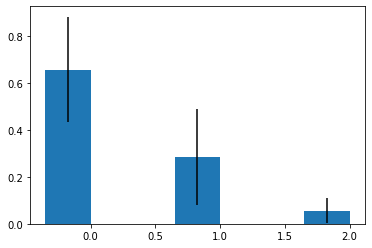

In [52]:
y_pred_sample = np.empty((0,num_classes))
for sample in y_pred_vals_raw:
#     print(np.random.multinomial(n=1, pvals=sample, size=10).shape)
    y_pred_sample = np.append(y_pred_sample, np.random.multinomial(n=1, pvals=sample, size=100), axis=0)
print(y_pred_sample.shape)

y_pred_sample_mean = np.sum(y_pred_sample, axis=0)
y_pred_sample_mean = y_pred_sample_mean/np.sum(y_pred_sample_mean)
print(y_pred_sample_mean.shape)
print(y_pred_sample_mean)

y_pred_sample_var = np.var(y_pred_sample, axis=0)
print(y_pred_sample_var)

width = 0.35
widths = [i-width/2 for i in range(num_classes)]
plt.bar(widths, y_pred_sample_mean, yerr=y_pred_sample_var, width=width, label='Wild Prediction')
plt.show()

(5680, 3)
[0.6119403  0.31044776 0.07761194]
(568000, 3)
(10, 568, 100, 3)
(10, 100, 3)
(1000, 3)


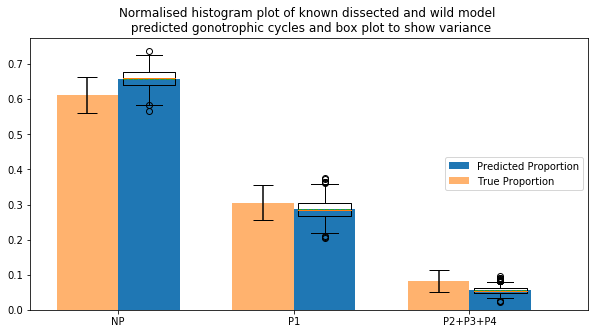

In [55]:
fig = plt.figure(figsize=(10,5))
plt.title(f'Normalised histogram plot of known dissected and wild model \n predicted gonotrophic cycles and box plot to show variance')

# y_pred_counts = np.unique(y_pred_vals, return_counts=True)[1]
# y_pred_counts = y_pred_counts/np.sum(y_pred_counts)
# print(y_pred_counts)

print(y_pred_vals_raw.shape)
y_pred_counts = np.mean(y_pred_vals_raw, axis=0)

# y_pred_counts = np.mean(y_pred_counts_out, axis=0)
# print(y_pred_counts)
y_true_counts = np.unique(data_extract.y_age_groups, return_counts=True)[1]
y_true_counts = y_true_counts/np.sum(y_true_counts)
print(y_true_counts)
width = 0.35
if len(y_pred_counts) == num_classes:
    widths = [i+width/2 for i in range(num_classes)]
elif len(y_pred_counts) == num_classes-1:
    widths = [i+width/2 for i in range(num_classes-1)]
else:
    widths = [0+width/2,1+width/2]
plt.bar(widths, y_pred_sample_mean, width=width, label='Predicted Proportion', color='tab:blue')
# if num_classes == 4:
#     plt.bar([0+width/2,1+width/2,2+width/2,3+width/2], y_true_counts, width=width, label='Known Dissected', color='red', alpha=0.6)
# elif num_classes == 3:
#     plt.bar([0+width/2,1+width/2,2+width/2], y_true_counts, width=width, label='Known Dissected', color='red', alpha=0.6)
plt.bar([0-width/2,1-width/2,2-width/2], true_means, yerr=ci95upper-true_means, width=width, label='True Proportion', color='tab:orange', alpha=0.6, capsize=10)
    
y_pred_vals_raw_out = np.reshape(y_pred_vals_raw, (10,-1,3))
y_pred_counts_out = np.mean(y_pred_vals_raw_out, axis=1)
print(y_pred_sample.shape)
y_pred_sample_box = np.reshape(y_pred_sample, (10,568,100,3))
print(y_pred_sample_box.shape)
y_pred_sample_box = np.mean(y_pred_sample_box, axis=1)
print(y_pred_sample_box.shape)
y_pred_sample_box = np.reshape(y_pred_sample_box, (1000,3))
print(y_pred_sample_box.shape)
np.savetxt(f'{savedir}bar_and_hist_model_sample_AC.txt', y_pred_sample_box)
plt.boxplot(y_pred_sample_box, positions=[0+width/2,1+width/2,2+width/2], meanline=True, showmeans=True)

if num_classes == 4:
    plt.xticks([0,1,2,3], ['NP', 'P1','P2', 'P3+P4'])
elif num_classes == 3:
#     plt.xticks([0,1,2], ['NP', 'P1+P2', 'P3+P4'])
    plt.xticks([0,1,2], ['NP', 'P1', 'P2+P3+P4'])

plt.legend(loc='right')
fig.patch.set_facecolor('xkcd:white')
plt.savefig(f'{savedir}bar_and_hist_model_sample.png', facecolor=fig.get_facecolor())
plt.show()

